In [8]:
# Intrusion Detection Using Supervised and Unsupervised Learning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.optim as optim


In [9]:
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Computer_networks/KDDTrain+.txt", header=None)
df_test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Computer_networks/KDDTest+.txt", header=None)

col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label", "attack_category"
]
df.columns = col_names
df_test.columns = col_names

# Drop attack category
df.drop('attack_category', axis=1, inplace=True)
df_test.drop('attack_category', axis=1, inplace=True)

# Label encode categorical features
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.transform(df_test[col])

# Convert labels to binary: normal vs attack
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
df_test['label'] = df_test['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# Encode label
label_encoder = LabelEncoder()

# Split data
y_train = label_encoder.fit_transform(df['label'])
y_test = label_encoder.fit_transform(df_test['label'])

# Scale features
X_train = StandardScaler().fit_transform(df.drop('label', axis=1))
X_test = StandardScaler().fit_transform(df_test.drop('label', axis=1))

fpr_dict, tpr_dict, auc_dict = {}, {}, {}

In [11]:
# ------------------------------
# Supervised Models
# ------------------------------
supervised_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

for name, model in supervised_models.items():
    print(f"\n--- {name} Evaluation ---")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds, target_names=['Normal', 'Attack']))
    print("\n" + "="*50 + "\n")
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    auc_dict[name] = auc(fpr, tpr)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

      Normal       0.91      0.68      0.78     12833
      Attack       0.69      0.91      0.78      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544




--- Random Forest Evaluation ---
              precision    recall  f1-score   support

      Normal       0.93      0.68      0.79     12833
      Attack       0.69      0.94      0.79      9711

    accuracy                           0.79     22544
   macro avg       0.81      0.81      0.79     22544
weighted avg       0.83      0.79      0.79     22544




--- SVM Evaluation ---
              precision    recall  f1-score   support

      Normal       0.98      0.70      0.81     12833
      Attack       0.71      0.98      0.82      9711

    accuracy                           0.82     22544
   macro avg       0.84   

In [10]:
# ------------------------------
# Unsupervised Models
# ------------------------------
X_train_unsup = X_train[y_train == label_encoder.transform(['normal'])[0]]

y_true = y_test

# Isolation Forest
iso_model = IsolationForest(contamination=0.1)
iso_model.fit(X_train_unsup)
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = [0 if y == -1 else 1 for y in y_pred_iso]  # -1: anomaly → 0: attack

print("----- Isolation Forest -----")
print(classification_report(y_true, y_pred_iso, target_names=label_encoder.classes_))


y_score_iso = iso_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score_iso)
fpr_dict['Isolation Forest'] = fpr
tpr_dict['Isolation Forest'] = tpr
auc_dict['Isolation Forest'] = auc(fpr, tpr)

# One-Class SVM
ocsvm = OneClassSVM(gamma='scale', nu=0.1)
ocsvm.fit(X_train_unsup)
y_pred_svm = ocsvm.predict(X_test)
y_pred_svm = [0 if y == -1 else 1 for y in y_pred_svm]  # -1: anomaly → 0: attack

print("----- One-Class SVM -----")
print(classification_report(y_true, y_pred_svm, target_names=label_encoder.classes_))

y_score_svm = ocsvm.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score_svm)
fpr_dict['One-Class SVM'] = fpr
tpr_dict['One-Class SVM'] = tpr
auc_dict['One-Class SVM'] = auc(fpr, tpr)


----- Isolation Forest -----
              precision    recall  f1-score   support

      attack       0.75      0.87      0.80     12833
      normal       0.78      0.62      0.69      9711

    accuracy                           0.76     22544
   macro avg       0.76      0.74      0.75     22544
weighted avg       0.76      0.76      0.75     22544

----- One-Class SVM -----
              precision    recall  f1-score   support

      attack       0.90      0.74      0.81     12833
      normal       0.72      0.89      0.80      9711

    accuracy                           0.81     22544
   macro avg       0.81      0.82      0.81     22544
weighted avg       0.82      0.81      0.81     22544



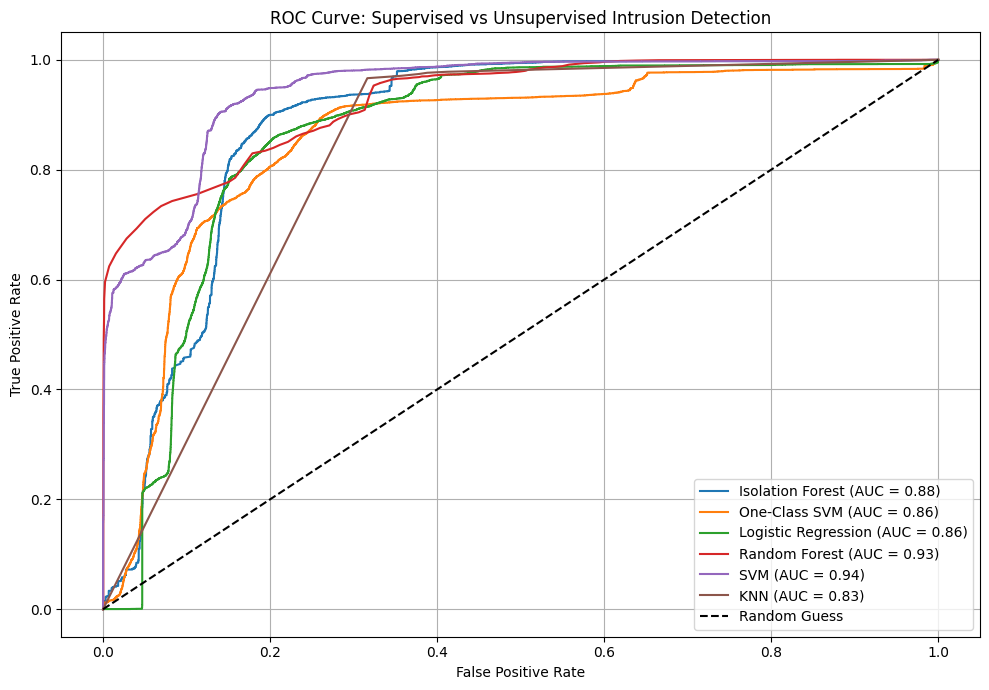

In [12]:
# ------------------------------
# Plot ROC Curve
# ------------------------------
plt.figure(figsize=(10, 7))
for name in fpr_dict:
    plt.plot(fpr_dict[name], tpr_dict[name], label=f"{name} (AUC = {auc_dict[name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Supervised vs Unsupervised Intrusion Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()